# Amazon reviews

> To get a better notebook formatting, [click here](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Project.ipynb).

This notebook contains an exploratory analysis of one specific category of products of the Amazon reviews. Our objective is to be able to understand how reviews are distributed and find some useful insights to provide a deeper analysis to answer our research questions.

## Summary

1. [Data importation](#Data-importation)
2. [Descriptive analysis](#Descriptive-analysis)
3. [Correlations](#Correlations)
4. [Machine learning exploratory](#Machine-learning-exploratory)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from matplotlib import pyplot as plt

## Data importation

We first start by importing data. Because we focus on one specific category (*video games*), we won't need to use Spark here.

### Download the data

We will use the 5-core reviews which can be downloaded here: http://jmcauley.ucsd.edu/data/amazon/links.html. The exact file used for video games import is http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz.

### File preparation

After downloading the file, we turn it to a valid, json array to ease importation. We use the following sed commands to do so:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i 's/$/,/' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Pandas importation

We import data and start by doing some simple cleaning. Dates are stored in two different formats (`reviewTime` and `unixReviewTime`). We will use the latest one to create a new `date` field with standard DateTime format, which will be easier to handle.

We create a two-level index to allow grouping reviews per product and reviewer.

In [3]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)

assert video_games.index.is_unique, 'There should be no more than one review per person per product'

video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

We can see data types are already guessed by Pandas. We need, however, to reformat the `helpful` field. It is currently stored as an array of two values, the first one describing how many users voted the review was helpful and the second one describing how many votes the review received.

### Data formatting

To ease data handling, we will calculate the `helpfulRate` of each comment. It will help us extracting which reviewers are providing the best reviews on one or multiple products. When a review does not have any helpful votes, the rate will be set to `-1`.

We also store the number of total reviews in a new row so we can take rid of the helpful array.

In [4]:
def helpful_rate(row):
    '''
    Calculates the helpful rate of a review by determining what
    percentage of the votes described the review as "helpful".
    '''
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return -1
    
    return was_helpful/total_evaluations

def helpful_count(row):
    '''
    Gets the total number of helpful votes for a review
    '''
    return row.helpful[1]

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)
video_games['helpfulCount'] = video_games.apply(helpful_count, axis=1)
del video_games['helpful']

assert len(video_games[video_games['helpfulCount'] == 0]) == len(video_games[video_games['helpfulRate'] == -1])

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  
asin       reviewerID                                            
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  
           A361M14PU2GUEG 2011-06-14     1.000000             2

Here is a first view of the data. All the reviews are grouped by product described by its product ID (`asin`). Then, for each product, all the reviews are indexed by the reviewer.

Each column of the dataframe is self-descriptive (notice that `overall` is the grade given from the reviewer in a scale between 1 and 5) and data types are allowing us to perform our analysis.

We now load *video games* metadata. The exact file used here is: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz. We had some trouble importing the file, so we had to make some transformations in addition to the `sed` ones, because strings were surrounded by simple quotes instead of double quotes. Here is the Python script we used:

```python
import ast
import json

with open('./data/video-games.meta.json', 'r') as metadata:
    raw_data = metadata.read().replace('\n', '')
    parsed_data = ast.literal_eval(raw_data)

with open('./data/video-games.meta.parsed.json', 'w') as parsed:
    json.dump(parsed_data, parsed)
```

In [5]:
video_games_meta = pd.read_json('./data/video-games.meta.parsed.json')

del video_games_meta['imUrl']
del video_games_meta['related'] # For now we remove related (also bought, also viewed and buy after viewing) products
del video_games_meta['categories'] # We get rid of the sub categories for now

video_games_meta.price.fillna(-1, inplace=True)
video_games_meta.title.fillna('', inplace=True)
video_games_meta.brand.fillna('', inplace=True)
video_games_meta.description.fillna('', inplace=True)

# The following line can be understood as:
# video_games_meta.salesRank.fillna({}, inplace=True)
# It is done using this process because Pandas won't take into account the empty {} with fillna()
video_games_meta.loc[video_games_meta['salesRank'].isnull(), ['salesRank']] = video_games_meta.loc[video_games_meta['salesRank'].isnull(), 'salesRank'].apply(lambda x: {})

video_games_meta.set_index(['asin'], inplace=True)

video_games_meta.head()

,brand,description,price,salesRank,title
asin,,,,,
0078764343,,Brand new sealed!,37.98,{'Video Games': 28655},
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,{'Video Games': 44080},
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,{'Video Games': 49836},
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,{'Video Games': 49156},
0439339960,,a scholastic clubs fairs cd rom game,-1.00,{'Video Games': 52262},


We need to get rid of the nested objects and arrays. We will take into account only the `salesRank` for video games section.

In [6]:
def sales_rank(row):
    '''
    Returns the video games sales rank from the sub object
    '''

    if not 'Video Games' in row.salesRank.keys():
        return -1
    
    return row.salesRank['Video Games']
    
video_games_meta['rank'] = video_games_meta.apply(sales_rank, axis=1)
del video_games_meta['salesRank']

video_games_meta.head()

,brand,description,price,title,rank
asin,,,,,
0078764343,,Brand new sealed!,37.98,,28655
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,,44080
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,,49836
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,,49156
0439339960,,a scholastic clubs fairs cd rom game,-1.00,,52262


Things are now clean in off to merge the two dataframes. We will allow to have duplicate `brand`, `description`, `price`, `title` and `rank` for each review as it will help finding correlations.

In [7]:
# We concatenate our dataframes based on the product ID index
video_games_ids = video_games.index.get_level_values('asin')

video_games['rank'] = video_games_meta.loc[video_games_ids]['rank'].values
video_games['description'] = video_games_meta.loc[video_games_ids]['description'].values
video_games['price'] = video_games_meta.loc[video_games_ids]['price'].values
video_games['title'] = video_games_meta.loc[video_games_ids]['title'].values
video_games['brand'] = video_games_meta.loc[video_games_ids]['brand'].values

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN  246.63              
           A3UR8NLLY1ZHCX  246.63              
           A1INA0F5CWW3J4  246.63              
           A1DLMTOTHQ4AST  246.63              
           A361M14PU2GUEG  246.63

## Descriptive analysis

Our descriptive analysis will focus on several metrics taken from the above dataframe. We will first focus on the distribution of reviews grade (`overall`) and then analyse "helpful evaluations" of reviews. Finally, we will start searching for patterns in data distribution to prepare work for the next milestone.

### Distribution of possible review grades

We start by using a box plot to visualize how grades are distributed.

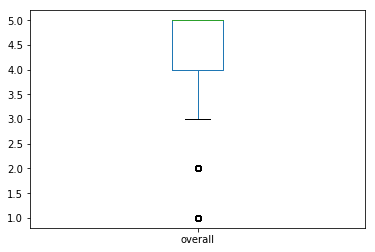

In [8]:
video_games.boxplot(column=['overall'], figsize=(8, 8), grid=False)

We can see that there is definitely more high grades (4, 5) than low ones. Let's describe data to get some insights.

In [9]:
video_games.overall.describe()

count    231780.000000
mean          4.086397
std           1.202330
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

We have 231780 reviews, with a mean of 4.08 and a standard deviation of 1.20.

When focusing at **robust statistics** only, we can see that the median is 5, and more than 75% of the reviews have awarded 4 or 5 grade to the product.

Let's see data distribution using a bar plot:

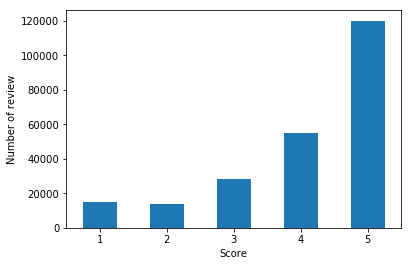

In [10]:
plt.xlabel('Score')
plt.ylabel('Number of review')
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

This confirms what was found before. We can do some assumptions about this distribution:

- The people may be more likely to thank the product quality by posting a review than to say their displeasure
- Amazon sell more good quality product (here video game) than bad one
- The 5 stars review can be due to the presence of fakes/paid review

We also can see that there are more reviews with `1` grade than `2`. This could be understood as people underrating products when they are not fully satisfied. It may also be used by customers to counterbalance a too high grade on a product, based on their opinions.

We now count the number of reviews per product to see if products are equally reviewed:

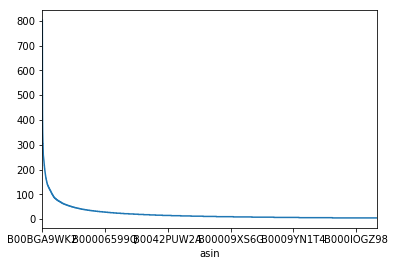

In [11]:
reviews_count_per_product = video_games.groupby(['asin']).overall.count().sort_values(ascending=False)

reviews_count_per_product.plot()

We seem to have a power law. However when using a logarithmic plot, we can see it is not:

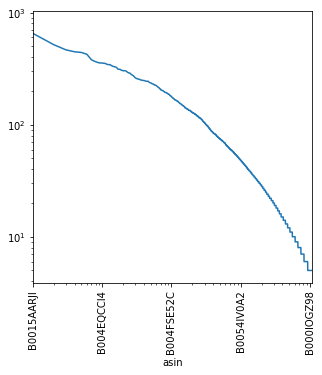

In [12]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

reviews_count_per_product.plot(logy=True, logx=True, rot=90, figsize=(5, 5))

Let's focus on the most reviewed product. The product is the "PlayStation 4 500GB Console".

In [13]:
most_reviewed = reviews_count_per_product.index[0]
most_reviewed_reviews = video_games.loc[most_reviewed]

most_reviewed_reviews.head()

,overall,reviewText,reviewerName,summary,date,helpfulRate,helpfulCount,rank,description,price,title,brand
reviewerID,,,,,,,,,,,,
A386ZNRX0TFFHX,4,I gave it 4 out of 5 stars because of lack of ...,NaN,"Great System, But...",2013-12-18,0.727273,11,13,,28.12,,
A2QYAFX7OCNRMO,3,PlayStation 4 is kind of hard to review right ...,NaN,Has potential...,2014-03-05,0.727273,11,13,,28.12,,
A3OQ3DU03L2GGO,5,Simply amazing. A huge step up from the PS3 an...,NaN,Stunning.,2013-12-01,0.727273,11,13,,28.12,,
A3H99DFEG68SR,3,So I've had the PS4 since launch and I have to...,1m2,I guess I expected more,2014-03-21,-1.000000,0,13,,28.12,,
A15LG7HS4WKKKS,5,Huge overall improvement over the PS3. The use...,"A. A. BADER ""Q8 AL BADER""","Best purchase all year.,",2014-03-06,0.700000,10,13,,28.12,,


We try to see if there are any trends in the reviews over time:

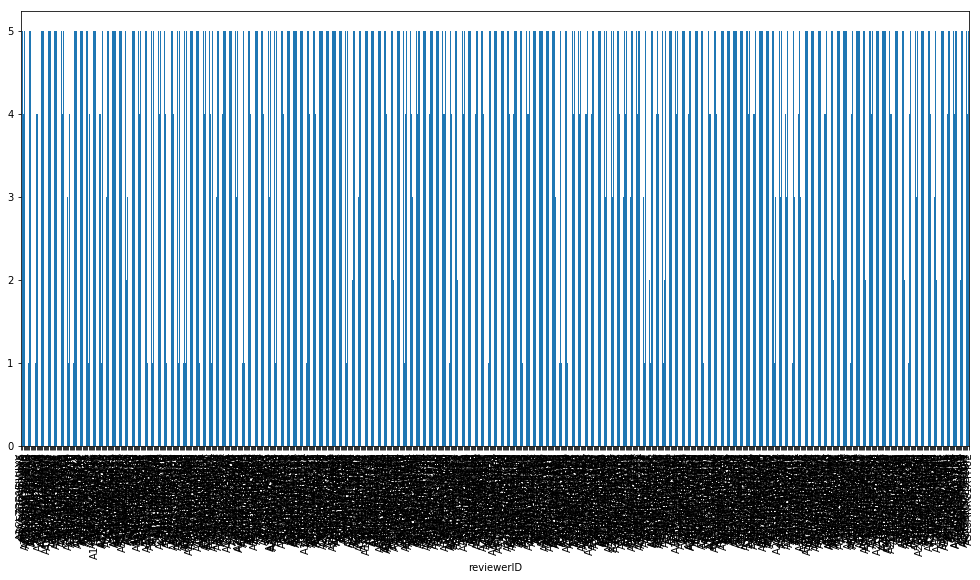

In [14]:
most_reviewed_reviews.sort_values(by=['date'], inplace=True)
most_reviewed_reviews.overall.plot(kind='bar', figsize=(17, 8), rot=90);

It is impossible to visually see any kind of trend. However, it may be possible using machine learning to determine if some grades can be deducted from the previous ones.

### Distribution of helpful rates

We do the same analysis for the helpful rate (after removing the reviews without evaluation):

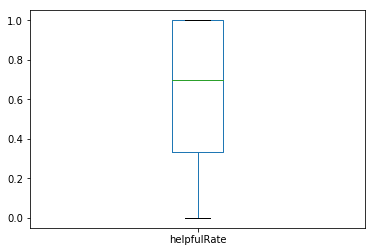

In [15]:
video_games[video_games.helpfulRate >= 0].boxplot(column=['helpfulRate'], figsize=(8, 8), grid=False);

Here, we can see rates are more widely distributed, let's do the same description as before.

In [16]:
video_games[video_games.helpfulRate >= 0].helpfulRate.describe()

count    139855.000000
mean          0.622347
std           0.369065
min           0.000000
25%           0.333333
50%           0.695652
75%           1.000000
max           1.000000
Name: helpfulRate, dtype: float64

Distribution seems more balanced, since first quartile is 0.33, median is 0.69 and last quartile is 0.75. We may however do the assumption that helpful reviews are more likely to be evaluated as even more helpful as Amazon will display those reviews first.

We now look at the distribution of helpful rates, considering all the sold products.

60.34% of reviews are evaluated


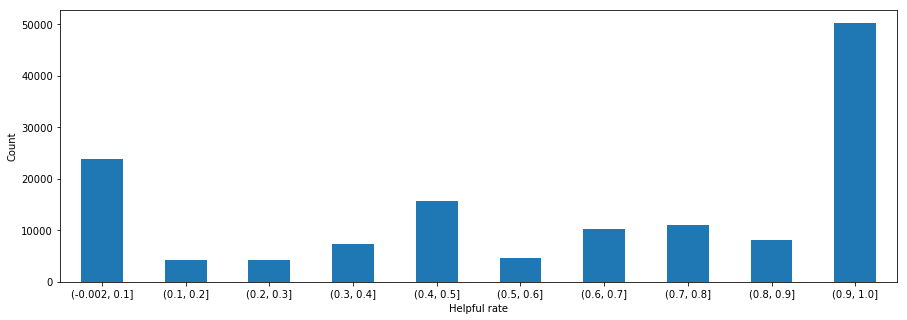

In [17]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate >= 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

plt.xlabel('Helpful rate')
plt.ylabel('Count')
helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5))

We can see two outsiders for reviews with less than 10% positive reviews and more than 90% positive reviews. This could be explained by the assumption made previously: the more a review is well rated, the more it is likely to get good rates. In the contrary, reviews with bad rates may be less visible on Amazon and may keep their low rates.

We will now sort the reviewers based on their helpful rate mean, to see if there are some top reviewers or very bad ones.

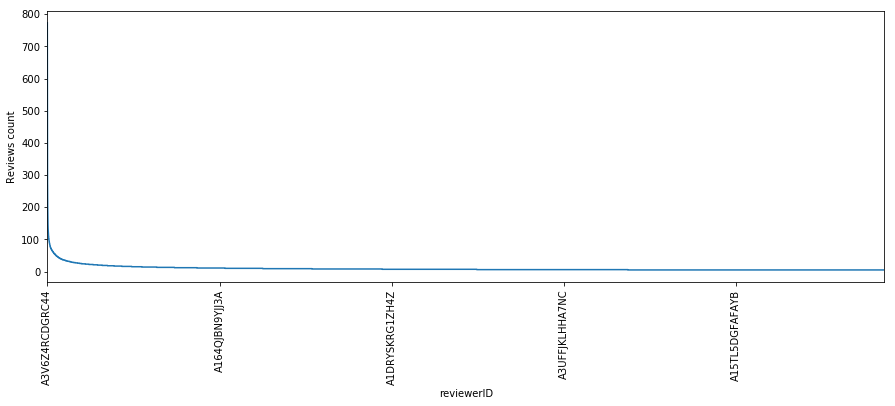

In [18]:
count_evaluations = video_games.groupby('reviewerID').count().sort_values('helpfulCount', ascending=False).helpfulRate

plt.ylabel('Reviews count')
count_evaluations.plot(rot=90, figsize=(15, 5))

We try to zoom to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 450
4th best evaluator: 404
5th best evaluator: 320


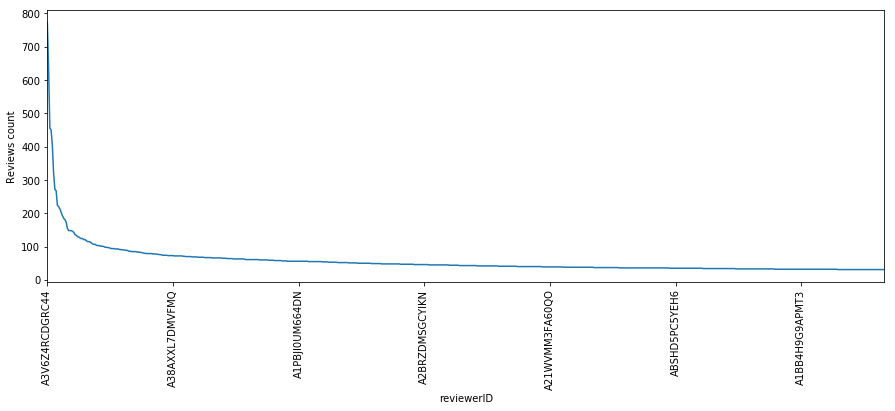

In [19]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
plt.ylabel('Reviews count')
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[3]))
print('4th best evaluator: ' + str(top_count_evaluations[4]))
print('5th best evaluator: ' + str(top_count_evaluations[5]))

We seem to have a power law here. We try to confirm this using a logarithmic plot:

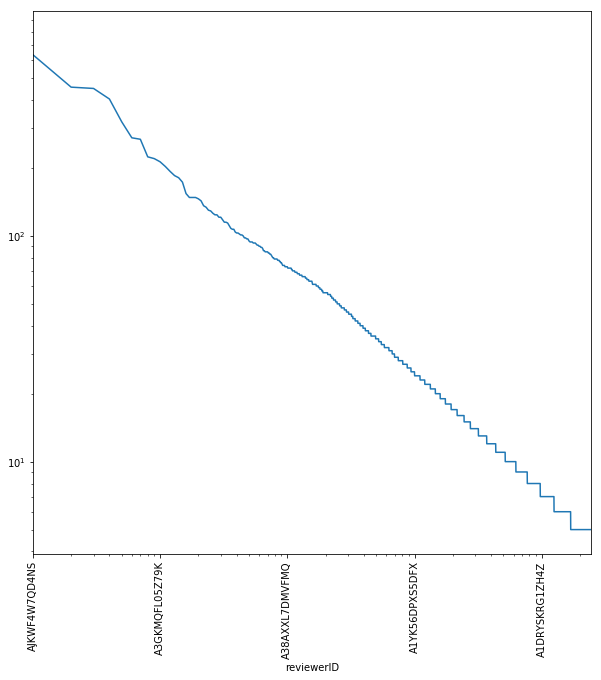

In [20]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

count_evaluations.plot(logy=True, logx=True, rot=90, figsize=(10, 10))

We indeed have a power law.

### Analysis of the more productive reviewer

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [21]:
best_reviewer_id = top_count_evaluations.index[0]


print('Number of reviews: ' + str(video_games.groupby('reviewerID').get_group(best_reviewer_id).helpfulCount.sum()))
video_games.groupby('reviewerID').get_group(best_reviewer_id).median()

Number of reviews: 21763


overall            5.000000
helpfulRate        0.888889
helpfulCount       9.000000
rank            8736.000000
price             29.990000
dtype: float64

Comparing it with the other reviewers:

In [22]:
video_games.overall.median()

5.0

In [23]:
video_games[video_games.helpfulRate >= 0].helpfulRate.median()

0.6956521739130435

The best evaluator seems to be a normal person, his `helpfulRate` is close to the median. He also gave more than 50% of 5 star grades. We don't get a lot of information here.

## Correlations

We add columns `reviewLength`, `summaryLength` and `reviewerNameLength` to the dataframe to take into account more metrics.

In [24]:
video_games['reviewLength'] = video_games['reviewText'].str.len()
video_games['summaryLength'] = video_games['summary'].str.len()
video_games['reviewerNameLength'] = video_games['reviewerName'].str.len()

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  reviewLength  summaryLength  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN  246.63                       779             40   
           A3UR8NLLY1ZHCX  246.63                       304             15   
           A1INA0F5CWW3J4  246.63                       282              9   
           A1DLMTOTHQ4AST  246.63                      3489             47   
           A361M14PU2GUEG  246.63                       294              6   

                           reviewerNameLength  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN                 3.0  
           A3UR8NLLY1ZHCX                34.0  
           A1INA0F5CWW3J4                26.0  
           A1DLMTOTHQ4AST                 8.0  
           A361M14PU2GUEG                28.0

We display the correlation matrix and scatter plot:

In [25]:
video_games.corr()

,overall,helpfulRate,helpfulCount,rank,price,reviewLength,summaryLength,reviewerNameLength
overall,1.000000,-0.133272,-0.086515,-0.103580,0.054490,-0.062702,-0.074934,-0.009812
helpfulRate,-0.133272,1.000000,0.121019,0.111745,0.024150,0.294168,0.176459,0.099486
helpfulCount,-0.086515,0.121019,1.000000,-0.004194,0.007926,0.132578,0.056005,0.024202
rank,-0.103580,0.111745,-0.004194,1.000000,-0.044552,0.025594,0.024808,0.068894
price,0.054490,0.024150,0.007926,-0.044552,1.000000,0.018523,0.021714,0.011590
reviewLength,-0.062702,0.294168,0.132578,0.025594,0.018523,1.000000,0.309684,0.098276
summaryLength,-0.074934,0.176459,0.056005,0.024808,0.021714,0.309684,1.000000,0.094540
reviewerNameLength,-0.009812,0.099486,0.024202,0.068894,0.011590,0.098276,0.094540,1.000000


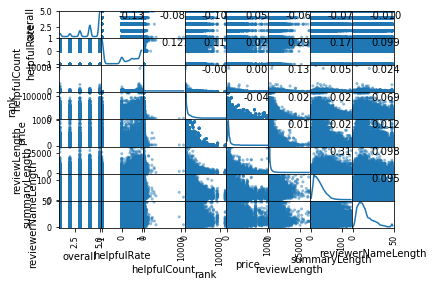

In [38]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(video_games, alpha=0.5, diagonal='kde')
corr = video_games.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

- There is some correlation between between `reviewLength` and the `helpfulRate`. We can think that more the `reviewLength` is high, more the review can contain more descriptions and arguments, so it can increase the helpfullness.   
- Then, the `summaryLength` and the `reviewLength` seems to be also correlated. The more the review text is lengthy, the more the summary needs letters to summarize it.

## Machine learning exploratory

We now use some machine learning methods to improve our analysis.

### TF-IDF 
We print the top 10 words for each review grouped by the overall score.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_words(text_series):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df=5) # Remove stop words and words appearing in less than 5 examples
    tfidf_matrix = vectorizer.fit_transform(text_series)
    feature_names = vectorizer.get_feature_names() 

    feature_array = np.array(feature_names)
    tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]

    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    return top_n


top_words_per_overall = pd.DataFrame()

for i in range(5):
    top_words_per_overall[i+1] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText)
top_words_per_overall

,1,2,3,4,5
0,used,pc,having,fairly,start
1,launch,games,released,pretty,ps3
2,going,ps4,fun,time,longer
3,money,day,love,buying,damn
4,make,playing,research,console,fee
5,console,bought,early,available,ps4
6,game,ps,problem,ve,button
7,good,xbox,hope,issues,charge
8,getting,just,wasn,far,options
9,gaming,console,little,gaming,playstation


We transform the review text to TF-IDF features to to the clustering

In [28]:
vectorizer = TfidfVectorizer(stop_words = 'english', min_df=5)
tfidf_matrix = vectorizer.fit_transform(most_reviewed_reviews.reviewText)

#### Clustering attempt

We try to determine if the occurences of certain word are specific to the a certain score. We try to cluster, using unsupervised learning, the reviews based on the tf-idf features to 5 groups. We hope we will find on each group the same overall score : 1 group for review score 1, another for score 2 etc...

##### KMeans

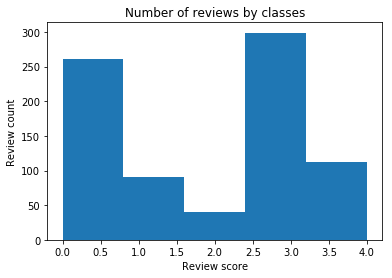

In [72]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5)
km.fit(tfidf_matrix)

plt.hist(km.labels_, bins=k)
plt.xlabel('Review score')
plt.ylabel('Review count')

plt.title('Number of reviews by classes')
plt.show()

In [73]:
clusters = {}

for i in set(km.labels_):
    #print i
    cluster = [most_reviewed_reviews.iloc[x] for x in np.where(km.labels_ == i)[0]]
    clusters[i] = pd.DataFrame(cluster)

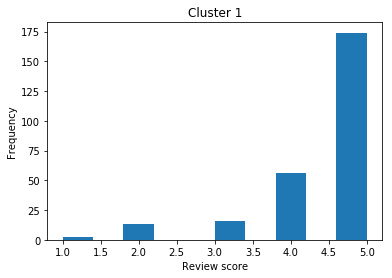

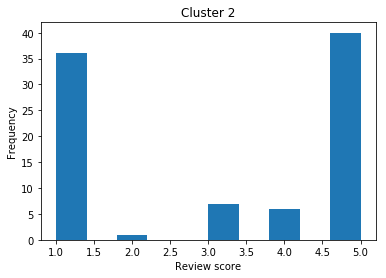

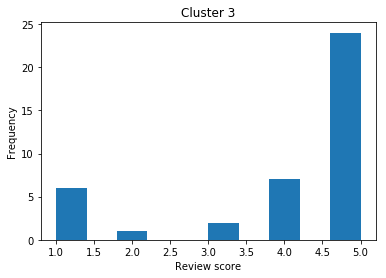

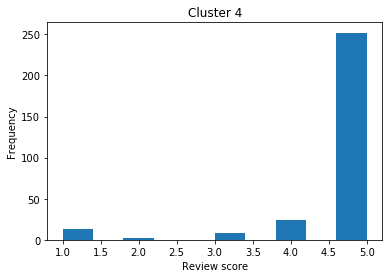

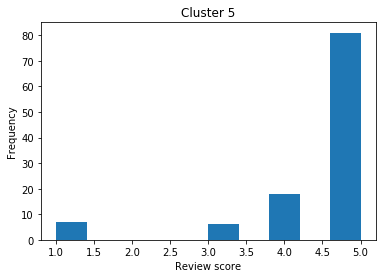

In [74]:
plt.title("Cluster 1")
plt.xlabel('Review score')
clusters[0].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 2")
plt.xlabel('Review score')
clusters[1].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 3")
plt.xlabel('Review score')
clusters[2].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 4")
plt.xlabel('Review score')
clusters[3].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 5")
plt.xlabel('Review score')
clusters[4].overall.plot(kind="hist");
plt.show()

It's not a great success.

##### Select only numeric data

In [35]:
playstation_numeric_reviews = most_reviewed_reviews._get_numeric_data().dropna()
playstation_numeric_reviews.head()

,overall,helpfulRate,helpfulCount,rank,price
reviewerID,,,,,
A2CLZBE0EJWJXX,5,0.166667,6,13,28.12
ABY5Z7DYBIQWS,5,0.000000,1,13,28.12
AD0SJOW5Z2VM6,4,0.590909,44,13,28.12
AOWO3CTZLNXYS,5,0.000000,1,13,28.12
A3FXV9BW1KUQ7H,1,0.583333,24,13,28.12


##### PCA

In [36]:
from sklearn.decomposition import PCA
n_components = 2

pca = PCA(n_components=n_components)
pca.fit(playstation_numeric_reviews)
pca_result = pd.DataFrame(pca.transform(playstation_numeric_reviews), columns=['PCA%i' % (i+1) for i in range(n_components)], index=playstation_numeric_reviews.index)
pca_result.head()

,PCA1,PCA2
reviewerID,,
A2CLZBE0EJWJXX,-4.938026,0.584427
ABY5Z7DYBIQWS,-9.938051,0.560867
AD0SJOW5Z2VM6,33.064475,-0.290210
AOWO3CTZLNXYS,-9.938051,0.560867
A3FXV9BW1KUQ7H,13.072103,-3.334095


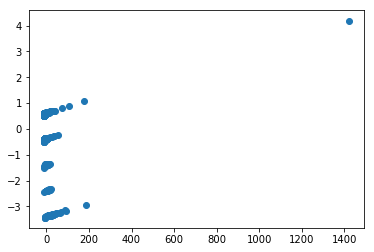

In [37]:
plt.scatter(pca_result.PCA1, pca_result.PCA2)
plt.show()